<center><h1> bolasso demonstration </h1></center>

## In this file, we carefully show the output of the key steps in "bolasso_parallel.py" (the parallel version of bolasso)


---

## Check the following before running the code

### (a) Read "README.pdf" in this folder first, which introduces the package

### (b) Before replication, delete all .p files in the "./numerical_result" folder. The .p files record the numerical results of the our computation.

### (c) To avoid confusion, reset your kernel before you running the notebook (to clear memory): 
* <font size="4.5"> In Jupyter Notebook/Lab : go to Menu "Kernel" $\rightarrow$ "Restart Kernel and clear all outputs". </font> 

### (d) To evaluate the code for simulation replication in Jupyter Notebook/Lab,
* <font size="4.5"> click : Menu "Kernel" $\rightarrow$ "Restart Kernel and Run All Cells" </font>
* <font size="4.5"> or, select a cell of code, press "shift" and "enter". Run all cells to avoid errors </font>

### (e) Check "joblib", "scikit-learn", "numpy", "matplotlib" and "tqdm" are installed. If not,
* <font size="4.5"> we highly recommend installing Anaconda3 version 2020-11 directly to avoid package management (all packages mentioned above are installed by default).</font>

---

## Preparation 1: we import all the packages

In [1]:
%reset -f

import numpy             as np
import matplotlib.pyplot as plt
import time
import warnings

from matplotlib.ticker    import MaxNLocator
from joblib               import Parallel, delayed
from sklearn.linear_model import LassoLarsCV, LinearRegression
from sklearn.exceptions   import ConvergenceWarning
from sklearn              import preprocessing
from importlib.metadata   import version

assert version('scikit-learn') <= '1.2.0', "Please make sure the scikit-learn version <= 1.2.0"

# For recent version of Scikit-learn: since the class 'Lars' may rely on the Cholesky decomposition and hence may have potential convergence warning in high dimensional data (p is much larger than n), we input the following commmand to skip the convergence warning.
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

## make sure we use the Intel MKL C++/Fortran compiler for maximum performance.

In [2]:
import mkl

mkl.get_version_string()

'Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications'

In [3]:
print('This was obtained using the following Numpy configuration:')

np.show_config()

This was obtained using the following Numpy configuration:
blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
Supported SIMD extensions in this NumPy install:
    


## Preparation 2 : we define the data generator for simulations (which is copied from "simulator.py")

In [4]:
class simul:

    def __init__(self, sample_size, n_dim, n_info):
    ##for convinience, we define the common variable (variables we need to use for each of the following functions) in the class as follows (the common variable is defined as self.xxxx)

        self.sample_size   = sample_size
        self.n_dim         = n_dim
        self.n_info        = n_info


    #data-generating process
    def data_gen(self):

        ##1. generating the covariance matrix for X,
        #we add a matrix full of 1/2 with an identity matrix multiplied with 1/2
        a = np.ones((self.n_dim, self.n_dim)) * 0.5; A = np.eye(self.n_dim)*0.5

        cov_x = a + A

        ##2. generating the mean of each column in X (which is 0)
        mean_x = np.zeros(self.n_dim)

        ##3. generating X as a multivariate Gaussian
        X = np.random.multivariate_normal(mean_x, cov_x, self.sample_size)

        ##4. generate regression coefficients in DGP as an increasing sequence (2,3,4,5,6 in our paper)
        beta_info = np.arange(2, self.n_info + 2)

        #in DGP, generate regression coefficients of redundant variables as 0
        #concatenate the regression coefficients of informative variables and redundant variables
        beta = np.concatenate((beta_info, np.zeros(self.n_dim - self.n_info)), axis = 0)

        ##5. generate the Gaussian random noise
        noise = np.random.normal(0, 1, self.sample_size)

        #transform Gaussian random noise into a column
        #transform regression coefficients in DGP into a row (based on the requirement of np.inner )
        noise.shape = (self.sample_size, 1); beta.shape = (1, self.n_dim)

        ##6. generate Y by adding random noise with the inner product of X and beta
        Y = np.inner(X,beta) + noise

        return X, Y

---

## Now we show the output of key steps in "bolasso_parallel.py"
* <font size="4.5"> using a parallel for-loop (coded with Joblib), bolasso trains a lasso on each bootstrap sample (based on a child random seed)</font>

## #1. firstly,  we only run the parallel for-loop once and check 
* <font size="4.5"> the random seed generation </font>
* <font size="4.5"> bootstrapping and bootstrap sample </font>
* <font size="4.5"> the lasso result on first bootstrap sample </font>
* <font size="4.5"> the variable "qhat_k" that we use to represent which variable is picked by lasso </font>

### after turning step 3 and 4 into comments, we only show the output of the first repetition in step 2.

In [5]:
class bolasso:

    def __init__(self, X, Y, n_repeat_bolasso, rnd=0):
        # for convinience, we define the common variable (variables we need to use for each of the following functions) in the class as follows (the common variable is defined as self.xxxx)

        # sample size
        self.sample_size = X.shape[0]
        # the number of subsamples generated in bolasso
        self.n_repeat_bolasso = n_repeat_bolasso
        # the number of total variables in X
        self.n_dim = X.shape[1]
        # randome seeds for parallel computations
        self.rnd = rnd
        # the maximum value of subsample selection frequency for plotting
        self.q_start = 1
        # the minimum value of subsample selection frequency for plotting
        self.q_end = 0.1
        # the sample we generate via data-generating process
        self.X = X; self.y = Y

    def fit(self):

        #1. construct a placeholder called 'qhat_k_container', which is the list of all qhat^k (a binary string representing whether each variable is selected by lasso on subsample k) of each subsample
        qhat_k_container = list()

        #2. train a lasso on each subsample, find out which variable is selected on a given sample and save the corresponding selection result on subsample k as qhat^k

        #parallel computing starts
        # 2a. to make parallel computing replicable, set random seeds
        np.random.seed(self.rnd)
        # 2b. spawn off child seed sequences to pass to child processes.
        seeds = np.random.randint(1e8, size=self.n_repeat_bolasso)

        # 2c. first we define what we do in each stage of the loop
        def loop_fun(self, i, seeds, qhat_k_container):

            # 2c(1). fix random seed for replication
            np.random.seed(seeds[i])

            # 2c(2). randomly choose a bootstrap set of sample points (whose index is 'index_subsample'); 
            # e.g. choosing n points from n points with replacement
            index_subsample = np.random.choice(self.sample_size, self.sample_size, replace=True)
            # 2c(3). based on the index "index_subsample", take the corresponding observations of X as "X_subample"
            X_subsample = self.X[index_subsample]
            # 2c(4). based on the index "index_subsample", take the corresponding observations of Y as "y_subample"
            y_subsample = self.y[index_subsample]

            # 2c(5). change dimension for the Sklearn lasso package.
            y_subsample.shape = (y_subsample.shape[0],)
            
            #standardize training data
            scaler = preprocessing.StandardScaler().fit(X_subsample)
            X_subsample = scaler.transform(X_subsample)

            # 2c(6). given a subsample, compute lasso and output the active set;
            # call the lasso class and set the number of fold as 10
            trial_1 = LassoLarsCV(cv=10, normalize=False)
            # fit lasso on the subsample
            trial_1.fit(X_subsample, y_subsample)
            # save the lasso active set (indices of variables select by lassso) as 'active'.
            active = trial_1.active_

            # 2c(7). based on the active set of lasso, we compute qhat^k as the binary string of whether each variable is selected by lasso on subsample K
            # we generate 'qhat_k' as a row of zeros;
            qhat_k = np.zeros((1, self.n_dim))
            # if a variable (the ith column in matrix X) is selected by lasso, we change the ith value of qhat_k (the ith column) as 1
            for i in active:

                qhat_k[0, i] = 1

            # we append the result into 'qhat_k_container' as one element of the list
            qhat_k_container.append(qhat_k)

            return seeds, index_subsample, X_subsample, y_subsample, active, qhat_k_container
        
        seeds, index_subsample, X_subsample, y_subsample, active, qhat_k_container = loop_fun(self, 0, seeds, qhat_k_container)
        
        return seeds, index_subsample, X_subsample, y_subsample, active, qhat_k_container
    
    '''
        # 2d. parallel the whole for-loop using the function we define previously and save the result
        # prefer="processes"  means that we prefer use processes
        # n_jobs=-1           means we use all possible processes
        qhat_k_container = Parallel(n_jobs=-1, prefer="processes")(delayed(loop_fun)(self, i, seeds, qhat_k_container) for i in range(self.n_repeat_bolasso))

        # 3. compute subsample selection frequency for all variables
        # 3a. we transform the list of all q_hat^k ('qhat_k_container') into a matrix ('qhat_k_container_matrix')
        # axis = 0 means we treat each item as a row in matrix;
        # row of the matrix   : the q_hat^k on a given subsample for all variables;
        # column of the matrix: the corresponding value of qhat^k for variable "X_i" on all subsamples;
        qhat_k_container_matrix = np.concatenate(qhat_k_container, axis=0)

        # 3b. compute the the value of qhat for each variable (the subsample selection frequency of each variable)
        # e.g., compute the mean of each column 
        qhat_value = np.mean(qhat_k_container_matrix, axis=0)

        # 3c. set 'Qc_list' as the container for the subsample selection frequencies of all variables, ranking in decreasing order.
        Qc_list = list()
        # 3d. set 'c_seq' as the sequence of subsample selection frequency in bolasso
        q_step = -0.02  #when I need a detailed subsample frequency table, I take it as -0.01; otherwise, I use -0.02 to speed up the computation. This option virtually have no effect on runtime and accuracy on my PC.
        c_seq = np.arange(1, 0.1, q_step)

        # 3e. for each value of c, generate Q(c) --- the set of variables with subsample frequency larger or equal to c;
        for j in c_seq:
            # 3e(1). define 'container' as the placeholder of Q(c) when c == j;
            container = list()

            for i in range(self.X.shape[1]):
                # 3e(2). include all variables into 'container' if their corresponding values in q-hat 
                # (the subsample selection frequency of X_i) are larger or equal to j;
                if (qhat_value[0][i] >= j):

                    container.append(i)
            # 3e(3). append 'container' (Q(c) when c == j) into 'Qc_list' (the container of Q(c) for all value of c);
            Qc_list.append(container)

        # 4. pick the variable that are selected most of the time;
        # 4a. find the active set and save it as 'Q_opt_c';
        # 4a(1). if it is bolasso-H, choose c == 1
        Q_opt_c_H = Qc_list[0]
        # 4a(2). if it is bolasso-S, choose c == 0.9
        Q_opt_c_S = Qc_list[5]

        # 5. output the bolasso-S result (Q_opt_c_S is the active set of bolasso-S)
        # 5a. if Q_opt_c_S is empty, return a zero array and empty active set
        if Q_opt_c_S == []:

            bolassoS_coef = np.zeros([self.n_dim, 1])
        # 5b. otherwise, regress Y onto the selected variables in X (variables in Q_opt_c_S)
        else:
            # 5b(1). call the LinearRegression class;
            OLS_S = LinearRegression()
            # 5b(2). fit OLS of Y to the variables in Q_opt_c_S on X;
            OLS_S.fit(self.X[:, Q_opt_c_S], self.y)
            # 5b(3). set 'bolassoS_coef' (an array of zeros) as the placeholder of bolasso-S regression coefficents
            bolassoS_coef = np.zeros([self.n_dim, 1])
            # 5b(4). put the estimated regression coefficents into their corresponding place of 'bolassoS_coef'
            bolassoS_coef[Q_opt_c_S, 0] = OLS_S.coef_

        # 5c. output the bolasso-H result (Q_opt_c_H is the active set of bolasso-H)
        # if Q_opt_c_H is empty, return a zero array and empty active set
        if Q_opt_c_H == []:

            bolassoH_coef = np.zeros([self.n_dim, 1])
        # 5d. otherwise, regress Y onto the selected variables in X (variables in Q_opt_c_H)
        else:
            # 5d(1). call the LinearRegression class;
            OLS_H = LinearRegression()
            # 5d(2). fit OLS of Y on the variables of Q_opt_c_H in X;
            OLS_H.fit(self.X[:, Q_opt_c_H], self.y)
            # 5d(3). set 'bolassoH_coef' (an array of zeros) as the placeholder of bolasso-H regression coefficents
            bolassoH_coef = np.zeros([self.n_dim, 1])
            # 5d(4). put the estimated regression coefficents into their corresponding place of 'bolassoH_coef'
            bolassoH_coef[Q_opt_c_H, 0] = OLS_H.coef_

        return bolassoS_coef, bolassoH_coef, Qc_list, Q_opt_c_S, Q_opt_c_H
        '''

### now run the function above under the following simulation setting

In [6]:
sample_size = 20
n_dim = 12
n_info = 5
n_repeat_bolasso = 256

np.random.seed(2)

# generate X and Y
trial1 = simul(sample_size, n_dim, n_info)
X, Y = trial1.data_gen()

# train bolasso
trial2 = bolasso(X, Y, n_repeat_bolasso)

seeds, index_subsample, X_subsample, y_subsample, active, qhat_k_container = trial2.fit()

## Now let's check the result

### check all 256 random seeds for each lasso repetition in bolasso

In [7]:
print(seeds)

[75434668  2215104 38712131 60969723 58554051 15039847 74753033 89739541
 40294130   374564 69941847 72039494 97308044 36256058 38290113 44989926
 48220334 23813720 76385105 83093157 36662093 99522452 86837363 86414067
 84418245 65931087 42384210 20865123 76916696 84442289 87950109 97193107
  8085927 64085280 83836865 78826761 26299065 30790271 37003808 93837855
 52216522 36129012 20832407 62515875 78031730 80102583 25486114 43886720
 80701568 49997732 78794278 15338984 99574516 49344785 26835279 53472298
 67679674 82950687 43513153 23752679  4548665 45168931 61795447 62962443
 98279854 61856850 16863323  2946944 12577166 60476003 85730869 53889932
 33057401 30818218  4730964 39831755 84283716 92123910 35625924 91812479
 43202548 21730435 83109044 14137320 34869070 25544340 11680535 71404429
 79466869   341845 20193840 56620337 39008425 51844771 26958943 36478149
 58289758 14393600 74773796 10086306 13722416 33111901 13715843 41336362
 34407373 47654887 58665877 88105161 85846399 34092

In [8]:
seeds.shape

(256,)

## check the orignal sample index for each observation in the bootstrap sample

In [9]:
obs_index = ['point ' + str(i) for i in index_subsample]
print(obs_index)

['point 10', 'point 19', 'point 7', 'point 8', 'point 11', 'point 7', 'point 19', 'point 10', 'point 9', 'point 14', 'point 18', 'point 16', 'point 13', 'point 14', 'point 17', 'point 16', 'point 14', 'point 0', 'point 7', 'point 13']


### and the corresponding dot plot
* <font size="4.5"> horizontal axis is the observation index in orignal sample </font>
* <font size="4.5"> if you find 3 dots on horizontal value "7", in this bootstrap sample, point 7 from the original sample appears 3 times </font>

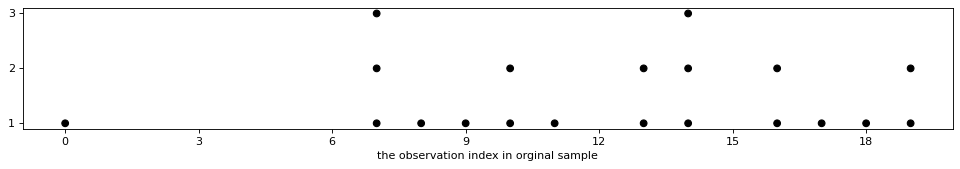

In [10]:
bins = 20

fig1 = plt.figure(figsize=(15, 2), dpi=80)
hist, edges = np.histogram(index_subsample, bins=bins)

y  = np.arange(1,hist.max()+1)
x  = np.arange(bins)
X,Y = np.meshgrid(x,y)

plt.scatter(X,Y, c=Y<=hist, cmap="Greys")

ax = fig1.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("the observation index in orginal sample")

plt.show()

## check the bootstrap sample size

In [11]:
print("the number of obs and the number of variables in a bootstrap sample :", X_subsample.shape)

the number of obs and the number of variables in a bootstrap sample : (20, 12)


In [12]:
print("the number of obs in a bootstrap sample :", y_subsample.shape)

the number of obs in a bootstrap sample : (20,)


## check the lasso active set on the first bootstrap sample

In [13]:
print("the active set of lasso :", active)

the active set of lasso : [4, 1, 7, 2, 3, 0, 5, 6]


## check variable "qhat_k" on the first bootstrap sample
* <font size="4.5"> if you find the $i^{th}$ value in "qhat_k" is 1, the $i^{th}$ variable is selected on this bootstrap sample</font>

In [14]:
print("the qhat for each varaible in X on the first bootstrap sample")
print(qhat_k_container)

the qhat for each varaible in X on the first bootstrap sample
[array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.]])]


---

## #2. now, let's check 
* <font size="4.5"> the qhat for 256 bootstrap samples </font>
* <font size="4.5"> the subsample selection frequency of all variables </font>
* <font size="4.5"> active set of bolasso-S and bolasso-H </font>

### we turning the last step into comments since it only produces the post-bolasso OLS coefficients.

In [15]:
class bolasso:

    def __init__(self, X, Y, n_repeat_bolasso, rnd=0):
        # for convinience, we define the common variable (variables we need to use for each of the following functions) in the class as follows (the common variable is defined as self.xxxx)

        # sample size
        self.sample_size = X.shape[0]
        # the number of subsamples generated in bolasso
        self.n_repeat_bolasso = n_repeat_bolasso
        # the number of total variables in X
        self.n_dim = X.shape[1]
        # randome seeds for parallel computations
        self.rnd = rnd
        # the maximum value of subsample selection frequency for plotting
        self.q_start = 1
        # the minimum value of subsample selection frequency for plotting
        self.q_end = 0.1
        # the sample we generate via data-generating process
        self.X = X; self.y = Y

    def fit(self):

        #1. construct a placeholder called 'qhat_k_container', which is the list of all qhat^k (a binary string representing whether each variable is selected by lasso on subsample k) of each subsample
        qhat_k_container = list()

        #2. train a lasso on each subsample, find out which variable is selected on a given sample and save the corresponding selection result on subsample k as qhat^k

        #parallel computing starts
        # 2a. to make parallel computing replicable, set random seeds
        np.random.seed(self.rnd)
        # 2b. spawn off child seed sequences to pass to child processes.
        seeds = np.random.randint(1e8, size=self.n_repeat_bolasso)

        # 2c. first we define what we do in each stage of the loop
        def loop_fun(self, i, seeds, qhat_k_container):

            # 2c(1). fix random seed for replication
            np.random.seed(seeds[i])

            # 2c(2). randomly choose a bootstrap set of sample points (whose index is 'index_subsample'); 
            # e.g. choosing n points from n points with replacement
            index_subsample = np.random.choice(self.sample_size, self.sample_size, replace=True)
            # 2c(3). based on the index "index_subsample", take the corresponding observations of X as "X_subample"
            X_subsample = self.X[index_subsample]
            # 2c(4). based on the index "index_subsample", take the corresponding observations of Y as "y_subample"
            y_subsample = self.y[index_subsample]

            # 2c(5). change dimension for the Sklearn lasso package.
            y_subsample.shape = (y_subsample.shape[0],)
            
            #standardize training data
            scaler = preprocessing.StandardScaler().fit(X_subsample)
            X_subsample = scaler.transform(X_subsample)

            # 2c(6). given a subsample, compute lasso and output the active set;
            # call the lasso class and set the number of fold as 10
            trial_1 = LassoLarsCV(cv=10, normalize=False)
            # fit lasso on the subsample
            trial_1.fit(X_subsample, y_subsample)
            # save the lasso active set (indices of variables select by lassso) as 'active'.
            active = trial_1.active_

            # 2c(7). based on the active set of lasso, we compute qhat^k as the binary string of whether each variable is selected by lasso on subsample K
            # we generate 'qhat_k' as a row of zeros;
            qhat_k = np.zeros((1, self.n_dim))
            # if a variable (the ith column in matrix X) is selected by lasso, we change the ith value of qhat_k (the ith column) as 1
            for i in active:

                qhat_k[0, i] = 1

            # we append the result into 'qhat_k_container' as one element of the list
            qhat_k_container.append(qhat_k)

            return qhat_k_container
    
        # 2d. parallel the whole for-loop using the function we define previously and save the result
        # prefer="processes"  means that we prefer use processes
        # n_jobs=-1           means we use all possible processes
        qhat_k_container = Parallel(n_jobs=-1, prefer="processes")(delayed(loop_fun)(self, i, seeds, qhat_k_container) for i in range(self.n_repeat_bolasso))

        # 3. compute subsample selection frequency for all variables
        # 3a. we transform the list of all q_hat^k ('qhat_k_container') into a matrix ('qhat_k_container_matrix')
        # axis = 0 means we treat each item as a row in matrix;
        # row of the matrix   : the q_hat^k on a given subsample for all variables;
        # column of the matrix: the corresponding value of qhat^k for variable "X_i" on all subsamples;
        qhat_k_container_matrix = np.concatenate(qhat_k_container, axis=0)

        # 3b. compute the the value of qhat for each variable (the subsample selection frequency of each variable)
        # e.g., compute the mean of each column 
        qhat_value = np.mean(qhat_k_container_matrix, axis=0)

        # 3c. set 'Qc_list' as the container for the subsample selection frequencies of all variables, ranking in decreasing order.
        Qc_list = list()
        # 3d. set 'c_seq' as the sequence of subsample selection frequency in bolasso
        q_step = -0.02  #when I need a detailed subsample frequency table, I take it as -0.01; otherwise, I use -0.02 to speed up the computation. This option virtually have no effect on runtime and accuracy on my PC.
        c_seq = np.arange(1, 0.1, q_step)

        # 3e. for each value of c, generate Q(c) --- the set of variables with subsample frequency larger or equal to c;
        for j in c_seq:
            # 3e(1). define 'container' as the placeholder of Q(c) when c == j;
            container = list()

            for i in range(self.X.shape[1]):
                # 3e(2). include all variables into 'container' if their corresponding values in q-hat 
                # (the subsample selection frequency of X_i) are larger or equal to j;
                if (qhat_value[0][i] >= j):

                    container.append(i)
            # 3e(3). append 'container' (Q(c) when c == j) into 'Qc_list' (the container of Q(c) for all value of c);
            Qc_list.append(container)

        # 4. pick the variable that are selected most of the time;
        # 4a. find the active set and save it as 'Q_opt_c';
        # 4a(1). if it is bolasso-H, choose c == 1
        Q_opt_c_H = Qc_list[0]
        # 4a(2). if it is bolasso-S, choose c == 0.9
        Q_opt_c_S = Qc_list[5]
        
        return qhat_k_container, qhat_value, Qc_list, Q_opt_c_H, Q_opt_c_S
        
        '''
        # 5. output the bolasso-S result (Q_opt_c_S is the active set of bolasso-S)
        # 5a. if Q_opt_c_S is empty, return a zero array and empty active set
        if Q_opt_c_S == []:

            bolassoS_coef = np.zeros([self.n_dim, 1])
        # 5b. otherwise, regress Y onto the selected variables in X (variables in Q_opt_c_S)
        else:
            # 5b(1). call the LinearRegression class;
            OLS_S = LinearRegression()
            # 5b(2). fit OLS of Y to the variables in Q_opt_c_S on X;
            OLS_S.fit(self.X[:, Q_opt_c_S], self.y)
            # 5b(3). set 'bolassoS_coef' (an array of zeros) as the placeholder of bolasso-S regression coefficents
            bolassoS_coef = np.zeros([self.n_dim, 1])
            # 5b(4). put the estimated regression coefficents into their corresponding place of 'bolassoS_coef'
            bolassoS_coef[Q_opt_c_S, 0] = OLS_S.coef_

        # 5c. output the bolasso-H result (Q_opt_c_H is the active set of bolasso-H)
        # if Q_opt_c_H is empty, return a zero array and empty active set
        if Q_opt_c_H == []:

            bolassoH_coef = np.zeros([self.n_dim, 1])
        # 5d. otherwise, regress Y onto the selected variables in X (variables in Q_opt_c_H)
        else:
            # 5d(1). call the LinearRegression class;
            OLS_H = LinearRegression()
            # 5d(2). fit OLS of Y on the variables of Q_opt_c_H in X;
            OLS_H.fit(self.X[:, Q_opt_c_H], self.y)
            # 5d(3). set 'bolassoH_coef' (an array of zeros) as the placeholder of bolasso-H regression coefficents
            bolassoH_coef = np.zeros([self.n_dim, 1])
            # 5d(4). put the estimated regression coefficents into their corresponding place of 'bolassoH_coef'
            bolassoH_coef[Q_opt_c_H, 0] = OLS_H.coef_

        return bolassoS_coef, bolassoH_coef, Qc_list, Q_opt_c_S, Q_opt_c_H
        '''

### now run the function above under the following simulation setting

In [16]:
sample_size      = 100
n_dim            = 12
n_info           = 5
n_repeat_bolasso = 256

np.random.seed(2)

# generate X and Y
trial1 = simul(sample_size, n_dim, n_info)
X, Y = trial1.data_gen()

# train bolasso
trial2 = bolasso(X, Y, n_repeat_bolasso)

qhat_k_container, qhat_value, Qc_list, Q_opt_c_H, Q_opt_c_S = trial2.fit()

### check the qhat for first 5 subsamples of bolasso

In [17]:
qhat_k_container[0:5]

[[array([[1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.]])],
 [array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])],
 [array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]])],
 [array([[1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.]])],
 [array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])]]

### check the subsample selection frequency of each varaible on 256 subsamples

In [18]:
print(qhat_value)

[[1.         1.         1.         1.         1.         0.55078125
  0.60351562 0.9609375  0.625      0.75       0.8515625  0.63085938]]


### and the corresponding barplot

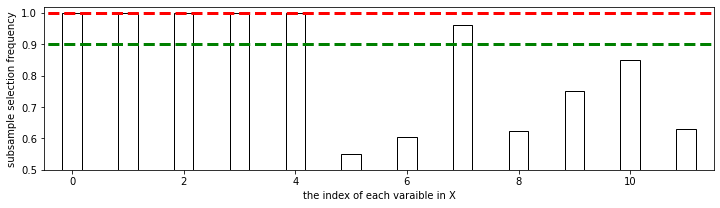

In [19]:
ind = np.arange(12)

fig, ax = plt.subplots(figsize=(12,3))

ax.bar(ind, qhat_value[0], 0.35, edgecolor="black", color="white")
ax.hlines(1, -1, 13, linewidth=3, color='red', linestyles='dashed')
ax.hlines(0.9, -1, 13, linewidth=3, color='green', linestyles='dashed')

ax.set_xlim([-0.5, 11.5])
ax.set_ylim([0.5, 1.02])

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("the index of each varaible in X")
plt.ylabel("subsample selection frequency")

plt.show()

## check the active set of bolasso

In [20]:
print("the active set with f=1.0 :", Q_opt_c_H)

the active set with f=1.0 : [0, 1, 2, 3, 4]


In [21]:
print("the active set with f=0.9 :", Q_opt_c_S)

the active set with f=0.9 : [0, 1, 2, 3, 4, 7]


## finaly, producing this into html

In [1]:
!rm -rf bolasso_walkthrough.html
!jupyter nbconvert --to html bolasso_walkthrough.ipynb 

[NbConvertApp] Converting notebook bolasso_walkthrough.ipynb to html
[NbConvertApp] Writing 695963 bytes to bolasso_walkthrough.html
